0 0.0005 0.0006065306597126335
1 0.00025 0.00036787944117144236
2 0.000125 0.00022313016014842985
3 6.25e-05 0.0001353352832366127
4 3.125e-05 8.20849986238988e-05
5 1.5625e-05 4.978706836786395e-05
6 7.8125e-06 3.0197383422318505e-05
7 3.90625e-06 1.8315638888734184e-05
8 1.953125e-06 1.1108996538242308e-05
9 9.765625e-07 6.737946999085468e-06


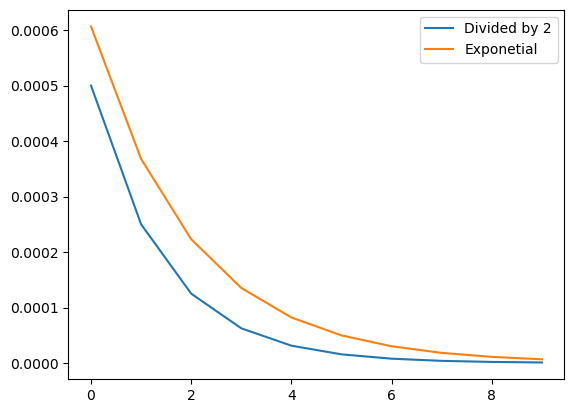

In [1]:
import numpy as np
import matplotlib.pyplot as plt

epoch = 10

lr_1 = 0.001
lr_2 = 0.001
lr_1_list = []
lr_2_list = []
for i in range(epoch):
    lr_1 = lr_1 * 0.5
    lr_2 = lr_2 * np.exp(-0.5)
    print(i, lr_1, lr_2)
    lr_1_list.append(lr_1)
    lr_2_list.append(lr_2)

plt.plot(range(epoch), lr_1_list, label="Divided by 2")
plt.plot(range(epoch), lr_2_list, label="Exponetial")
plt.legend();

## CSV Logger

In [32]:
import os
import pickle

import tensorflow as tf
import wandb
from wandb.keras import WandbCallback
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from modules.dataset import Dataset
from modules.models import Model
from modules.parser import parse_option

In [33]:
def lr_schedule(epoch, learning_rate):
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

In [35]:
# option = parse_option()
option = True
weight_option = 'imagenet' if option else None

# Constant variables
NAME = "Resnet50"
EPOCHS = 100
NUM_FOLDS = 5

# Callbacks
model_checkpoint_callback = ModelCheckpoint(f'results/models/{NAME}.h5', monitor='val_loss', mode='min', save_best_only=True)
early_stop_callback = EarlyStopping(monitor='val_loss', mode="min", patience=20, verbose=1)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', mode="min", factor=0.5, patience=5, verbose=1)
lr_logging_callback = LearningRateScheduler(lr_schedule)

In [36]:
dataset = Dataset()
for fold_num in range(1, NUM_FOLDS + 1):
    
    # CSV Logger
    path = os.path.join("results", "history", NAME)
    os.makedirs(path, exist_ok=True)
    csv_logger = CSVLogger(os.path.join(path, f"fold_{fold_num}.csv"))
    
    # Dataset
    train_dataset, test_dataset = dataset.get_kfold(fold_num, sample=True)
    
    # Modeling
    transfer_model = tf.keras.applications.resnet50.ResNet50(
        include_top=False, 
        weights=weight_option,
        input_shape=(224, 224, 3),
        pooling=None
    )
    model = Model(transfer_model).get_model(flatten=True)
    model.summary()
    
    # Visualize
    history = model.fit(
            train_dataset,
            epochs=EPOCHS,
            validation_data=test_dataset,
            verbose=1,
            # callbacks=[WandbCallback()],
            callbacks=[model_checkpoint_callback, csv_logger, early_stop_callback, reduce_lr_callback, lr_logging_callback]
    )
    
    # break

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_14 (Flatten)        (None, 100352)            0         
                                                                 
 dense_70 (Dense)            (None, 128)               12845184  
                                                                 
 dense_71 (Dense)            (None, 128)               16512     
                                                                 
 dense_72 (Dense)            (None, 64)                8256      
                                                                 
 dense_73 (Dense)            (None, 64)                4160      
                                                                 
 dense_74 (Dense)            (None, 15)              

In [37]:
import pandas as pd

pd.read_csv("results/history/Resnet50/fold_1.csv")

,epoch,auc_14,loss,val_auc_14,val_loss
0,0,0.543873,0.344908,0.495432,0.407070
1,1,0.564923,0.220604,0.439384,0.250341
2,2,0.620595,0.213311,0.518719,0.243452
3,3,0.659176,0.207349,0.532511,0.293387
4,4,0.715497,0.196907,0.505843,0.255570
5,5,0.776863,0.181363,0.524408,0.277555
6,6,0.803859,0.175622,0.522431,0.245467
7,7,0.859983,0.156107,0.511414,0.304781
8,8,0.924579,0.124180,0.545029,0.323503
9,9,0.971885,0.088136,0.508241,0.345958


In [38]:
pd.read_csv("results/history/Resnet50/fold_2.csv")

,epoch,auc_15,loss,val_auc_15,val_loss
0,0,0.549209,0.328484,0.460617,19.833015
1,1,0.633587,0.215444,0.466667,24.978901
2,2,0.694868,0.202243,0.416347,0.279881
3,3,0.801480,0.179690,0.460878,0.216734
4,4,0.830194,0.173048,0.398180,0.474231
5,5,0.768488,0.189831,0.482807,0.226738
6,6,0.865866,0.159410,0.439065,0.237037
7,7,0.913941,0.136700,0.477500,0.347172
8,8,0.940493,0.114527,0.454428,0.329909
9,9,0.973578,0.082219,0.465235,0.482997
